In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import KeyFunctions as me
import skopt as skopt
import warnings

warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")

RandState = 117

In [2]:
#Import Triclosan Data

from sympy.discrete.transforms import fwht, ifwht
import glob

df, labels = me.ConstructCombinedTriclosanDataset()
display(labels)

['10-3', '10-4', '10-5', '10-7', '10-8', '10-9']

In [3]:
#Perform Train Test Split

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(4, shuffle = True)

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()


In [4]:
#Scale Dataset

from sklearn.preprocessing import StandardScaler

Scale = StandardScaler()

X_tn = Scale.fit_transform(X_tn)
X_tt = Scale.transform(X_tt)

In [5]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

df.columns = df.columns.astype(str)

KNN = KNeighborsClassifier()

KNNscore = cross_val_score(KNN, X_tn, y_tn, cv = cv)
display("K-Nearest Cross Validation")
display(KNNscore)
display(np.mean(KNNscore))

KNNcv = cross_validate(KNN, X_tn, y_tn, cv = cv)
display(np.mean(KNNcv['fit_time']))

'K-Nearest Cross Validation'

array([0.6       , 0.6       , 0.5       , 0.55555556])

0.5638888888888889

0.0

In [6]:
params = dict()
params['metric'] = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
params['n_neighbors'] = (2, 10, 'uniform')
params['weights'] = ['uniform', 'distance']

Bayes = skopt.BayesSearchCV(KNN, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = cv)
KNNBS = Bayes.fit(X_tn, y_tn)
display()

display(KNNBS.best_params_)
ypred = KNNBS.predict(X_tt)
display(KNNBS.best_score_)
display(KNNBS.cv_results_['std_test_score'][KNNBS.best_index_])
display(KNNBS.refit_time_)

OrderedDict([('metric', 'minkowski'),
             ('n_neighbors', 2),
             ('weights', 'distance')])

0.7388888888888889

0.16187558093703852

0.0

In [7]:
from sklearn.metrics import confusion_matrix
y_pred = KNNBS.predict(X_tt)

KNNcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        KNNcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(KNNcounter))

CMNT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 0, Predicted: 10-7; Actual: 10-5'

'Incorrect Prediction at 1, Predicted: 10-9; Actual: 10-7'

'Incorrect Prediction at 3, Predicted: 10-7; Actual: 10-5'

'Total Predictions: 9'

'Total Errors: 3'

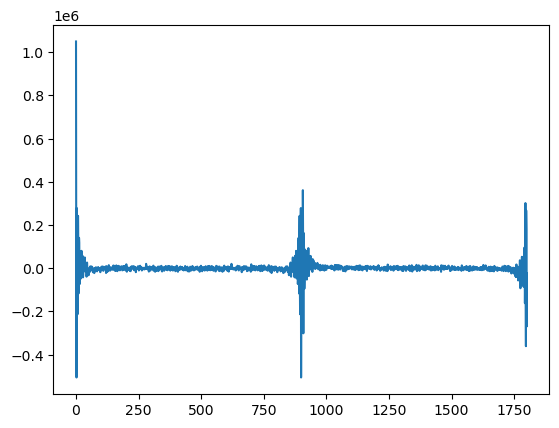

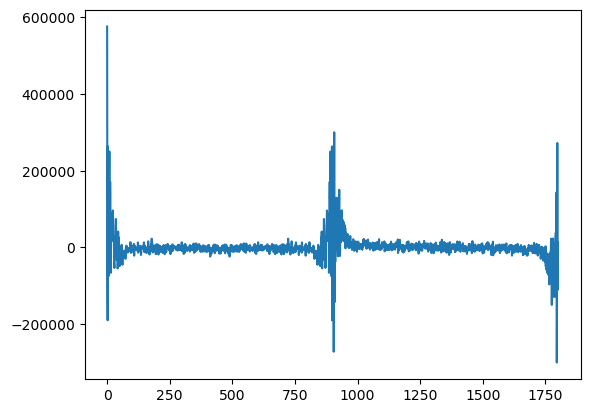

In [8]:
#Apply Fourier Transform to Training and Testing Data
#Fourier Transform Performs Best Without Scaling
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnf = np.fft.fft(X_tn)
X_ttf = np.fft.fft(X_tt)

#Data is stored as columns of all real values followed by columns of all imaginary values.
X_tnf = np.append(np.real(X_tnf), np.imag(X_tnf), axis = 1)
X_ttf = np.append(np.real(X_ttf), np.imag(X_ttf), axis = 1)

plt.figure()
plt.plot(X_tnf[1, :])
plt.figure()
plt.plot(X_tnf[7, :]);

In [9]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

KNN = KNeighborsClassifier()

KNNscore = cross_val_score(KNN, X_tnf, y_tn, cv = cv)
display("K-Nearest Cross Validation")
display(KNNscore)
display(np.mean(KNNscore))

KNNcv = cross_validate(KNN, X_tnf, y_tn, cv = cv)
display(np.mean(KNNcv['fit_time']))

'K-Nearest Cross Validation'

array([0.5       , 0.6       , 0.5       , 0.55555556])

0.538888888888889

0.0039441585540771484

In [10]:
params = dict()
params['metric'] = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
params['n_neighbors'] = (2, 10, 'uniform')
params['weights'] = ['uniform', 'distance']

Bayes = skopt.BayesSearchCV(KNN, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = cv)
KNNBS = Bayes.fit(X_tnf, y_tn)
display()

display(KNNBS.best_params_)
ypred = KNNBS.predict(X_ttf)
display(KNNBS.best_score_)
display(KNNBS.cv_results_['std_test_score'][KNNBS.best_index_])
display(KNNBS.refit_time_)

OrderedDict([('metric', 'minkowski'),
             ('n_neighbors', 2),
             ('weights', 'distance')])

0.7444444444444445

0.04513354669242204

0.0

In [11]:
y_pred = KNNBS.predict(X_ttf)

KNNcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        KNNcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(KNNcounter))

CMFT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 0, Predicted: 10-7; Actual: 10-5'

'Incorrect Prediction at 3, Predicted: 10-7; Actual: 10-5'

'Total Predictions: 9'

'Total Errors: 2'

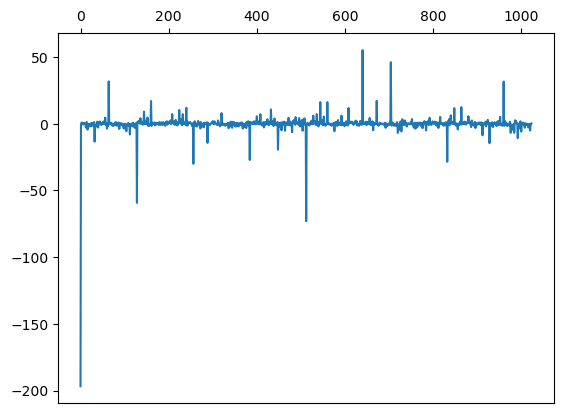

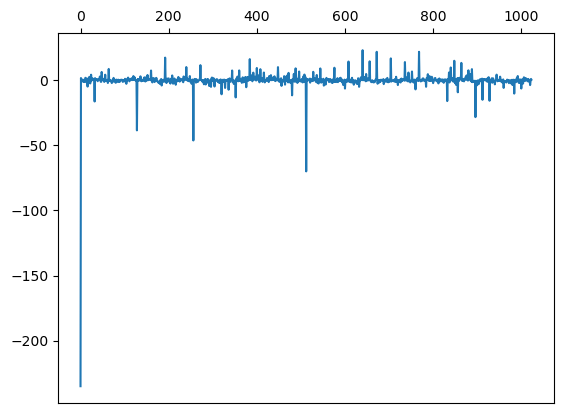

In [20]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tt = test.to_numpy()
X_tn = train.to_numpy()

Scale = StandardScaler()

X_tn = Scale.fit_transform(X_tn)
X_tt = Scale.transform(X_tt)

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tn)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)

plt.figure()
plt.plot(X_tnh[1, :])
plt.figure()
plt.plot(X_tnh[7, :]);

In [21]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

KNN = KNeighborsClassifier()

KNNscore = cross_val_score(KNN, X_tnh, y_tn, cv = cv)
display("K-Nearest Cross Validation")
display(KNNscore)
display(np.mean(KNNscore))

KNNcv = cross_validate(KNN, X_tnh, y_tn, cv = cv)
display(np.mean(KNNcv['fit_time']))

'K-Nearest Cross Validation'

array([0.7       , 0.5       , 0.7       , 0.66666667])

0.6416666666666666

0.06660670042037964

In [22]:
params = dict()
params['metric'] = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
params['n_neighbors'] = (2, 10, 'uniform')
params['weights'] = ['uniform', 'distance']

Bayes = skopt.BayesSearchCV(KNN, search_spaces = params, n_jobs = 6,
                      return_train_score = True, random_state = RandState, cv = cv)
KNNBS = Bayes.fit(X_tnh, y_tn)
display()

display(KNNBS.best_params_)
ypred = KNNBS.predict(X_tth)
display(KNNBS.best_score_)
display(KNNBS.cv_results_['std_test_score'][KNNBS.best_index_])
display(KNNBS.refit_time_)

OrderedDict([('metric', 'euclidean'),
             ('n_neighbors', 2),
             ('weights', 'distance')])

0.7722222222222223

0.07876359377087681

0.09374284744262695

In [15]:
y_pred = KNNBS.predict(X_tth)

KNNcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        KNNcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(KNNcounter))

CMHT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 0, Predicted: 10-7; Actual: 10-5'

'Incorrect Prediction at 1, Predicted: 10-9; Actual: 10-7'

'Incorrect Prediction at 3, Predicted: 10-7; Actual: 10-5'

'Total Predictions: 9'

'Total Errors: 3'

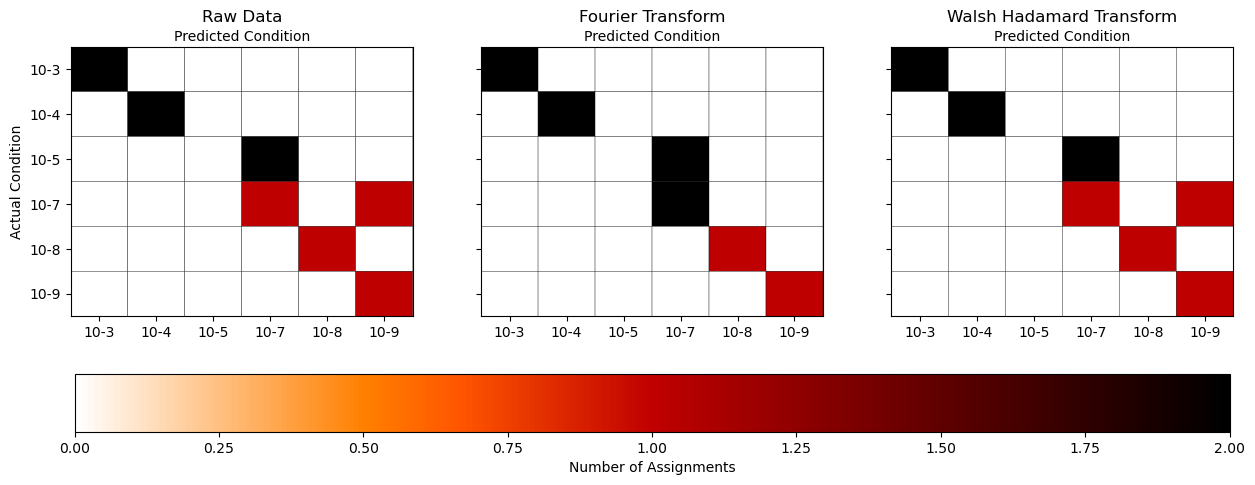

In [16]:

fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMNT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');